# PWA System Identification

In this notebook, we implement some methods for PWA system identification. The identification problem for a fixed number of regions can be posed as
$$ \min_{\Theta, \mathcal{R}} \frac{1}{M} \sum_{\ell=1}^M\sum_{i=1}^s \mathbf{1}_{z_\ell\in\mathcal{R}_i}\textrm{loss}(y_\ell - \theta_i^\top \begin{bmatrix} z_\ell \\ 1\end{bmatrix}) $$
which is a mixed integer problem, and is NP-hard to solve [cite]. Instead, we will investigate solving the problem by two approaches: a convex relaxation that has recovery guarantees with some assumptions, and a greedy alternating algorithm for clustering. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg as la
import sys

sys.path.append('../src')
import pwa_cluster as pwac

## Data Generation

Recall that a PWA system takes the following form
$$ y = \theta_i^\top \begin{bmatrix} z \\ 1 \end{bmatrix}, \quad z\in\mathcal{R}_i $$
Furthermore, recall that affine regions $\{\mathcal{R}_i\}_{i\in[s]}$ can be defined by $\{w_i\in\mathbb{R}^{d+1}\}_{i\in[s]}$
$$ z\in\mathcal{R}_i \iff i = \arg\max_{j\in[s]} w_j^\top \begin{bmatrix} z \\ 1 \end{bmatrix} $$

In this section, we write methods for generating noisy data. We will both generate data from a truly PWA system and from a nonlinear system that may be approximated as PWA.

In [3]:
def affine_fn(x, region, affines):
    return affines[region(x)].transpose().dot(np.hstack([x, [1]]))

def generate_affine_fn(d, n, s):
    affines = [np.random.rand(d+1, n) for i in range(s)]
    region_weights = [4*np.random.rand(d+1) for i in range(s)]
    def region(x):
        dot_pdt = [region_weight.transpose().dot(np.hstack([x, [1]])) for region_weight in region_weights]
        return np.argmax(dot_pdt)
    return lambda x: affine_fn(x, region, affines), region, affines
        
    


In [4]:
f, region, affines = generate_affine_fn(2, 1, 3)

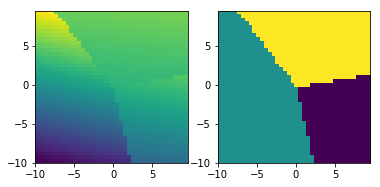

In [5]:
grid_size = 0.5
x = np.arange(-10,10,grid_size)
N_grid = len(x)

y = np.zeros([N_grid,N_grid])
regions = np.zeros([N_grid,N_grid])
xs = []
for i in range(N_grid):
    for j in range(N_grid):
        perturb = 0.25 * np.random.rand(2)
        y[i,j] = f([x[i],x[j]])
        regions[i,j] = region([x[i],x[j]])
        xs.append([x[i],x[j]])

plt.figure(); 
plt.subplot(1,2,1)
plt.imshow(y, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))
plt.subplot(1,2,2)
plt.imshow(regions, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))

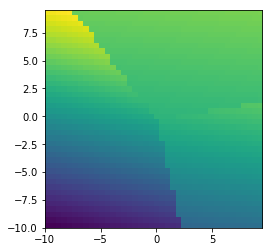

In [6]:
zs = np.array(xs)
ys = []
cluster_labels_true = []
for z in zs:
    ys.append(f(z) + 0 * np.random.randn(1))
    cluster_labels_true.append(region(z))
ys = np.array(ys)

plt.figure(); plt.imshow(ys.reshape(N_grid, N_grid), interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))


In [16]:
# to do: implement some realistic-ish nonlinear function (using the bicycle model?)

In [7]:
zs1 = zs[::2]
ys1 = ys[::2]

zs2 = zs[1::2]
ys2 = ys[1::2]

## Greedy Alternating Approach

In [8]:

clustering = pwac.ClusterPWA.from_num_clusters(zs1, ys1, 3) #, z_cutoff = 1)


In [9]:
clustering.fit_clusters(verbose=True)

assigning datapoints to clusters
updating models
6.65956587264
assigning datapoints to clusters
updating models
2.88292253248
assigning datapoints to clusters
updating models
1.72156416954
assigning datapoints to clusters
updating models
0.602386041232
assigning datapoints to clusters
updating models
0.158622526216
assigning datapoints to clusters
updating models
0.0427330839905
assigning datapoints to clusters
updating models
0.0319343899811
assigning datapoints to clusters
updating models
0.0281520639908
assigning datapoints to clusters
updating models
0.0
done


In [18]:
np.amax(np.abs(clustering.get_prediction_errors()))

1.8770384924884453

In [17]:
np.amax(np.abs(clustering.get_prediction_errors(new_zs=zs2, new_ys=ys2)))

4.6196318948347628

In [19]:
clustering.determine_polytopic_regions()

In [20]:
np.amax(np.abs(clustering.get_prediction_errors(new_zs=zs2, new_ys=ys2)))

4.6196318948347539

In [23]:
centroids_first = clustering.centroids.copy()
cluster_labels_first = clustering.cluster_labels.copy()
thetas_first = clustering.thetas.copy()

In [24]:
clustering.add_data_update(zs2, ys2, verbose=True)

assigning datapoints to clusters
updating models
assigning datapoints to clusters
updating models
0.14348055579
assigning datapoints to clusters
updating models
0.138611471765
assigning datapoints to clusters
updating models
0.134834441193
assigning datapoints to clusters
updating models
0.0747287259888
assigning datapoints to clusters
updating models
0.0759792035955
assigning datapoints to clusters
updating models
0.0350874534904
assigning datapoints to clusters
updating models
0.075694236572
assigning datapoints to clusters
updating models
0.107767959622
assigning datapoints to clusters
updating models
0.0729719466903
assigning datapoints to clusters
updating models
0.0775068200609
assigning datapoints to clusters
updating models
0.0894724203122
assigning datapoints to clusters
updating models
0.0187655794952
assigning datapoints to clusters
updating models
0.0345335515791
assigning datapoints to clusters
updating models
0.0204070388184
assigning datapoints to clusters
updating model

In [25]:
centroids_second = clustering.centroids.copy()
cluster_labels_second = clustering.cluster_labels.copy()
thetas_second = clustering.thetas.copy()

In [29]:
np.amax(np.abs(clustering.get_prediction_errors()))


4.5792558159713952

In [30]:
np.amax(np.abs(clustering.get_prediction_errors(new_zs=zs2, new_ys=ys2)))

4.5792558159713952

In [28]:
clustering.determine_polytopic_regions()

In [31]:
centroids = clustering.centroids
cluster_labels = clustering.cluster_labels
thetas = clustering.thetas

(-10.997670250896057,
 10.497670250896059,
 -10.990176600441503,
 10.490176600441501)

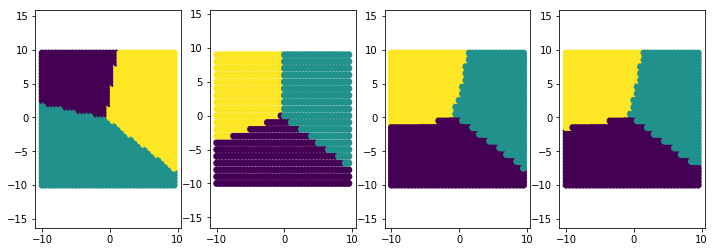

In [32]:
plt.figure(figsize=(12,4));
plt.subplot(1,4,1);
plt.scatter(zs[:,0], zs[:,1], c=cluster_labels_true); plt.axis('equal')

# plt.imshow((regions).T, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))

plt.subplot(1,4,2); plt.scatter(zs1[:,0], zs1[:,1], c=cluster_labels_first); plt.axis('equal')
zstack = np.vstack([zs1, zs2])
plt.subplot(1,4,3); plt.scatter(zstack[:,0], zstack[:,1], c=cluster_labels_second); plt.axis('equal')
plt.subplot(1,4,4); plt.scatter(zstack[:,0], zstack[:,1], c=cluster_labels); plt.axis('equal')


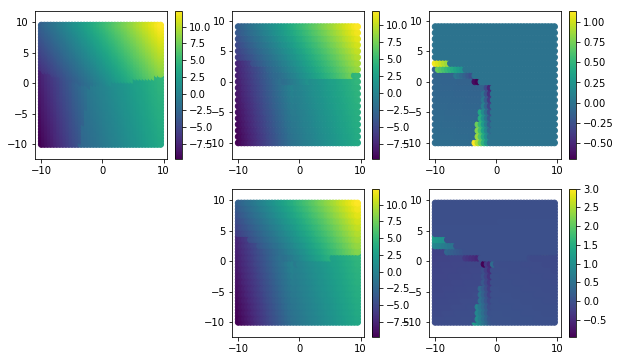

In [85]:
yhats = []
yhats_first = []
for i in range(zstack.shape[0]):
    yhat = thetas[int(cluster_labels[i])].transpose().dot(np.hstack([zstack[i], 1]))
    if i < zs1.shape[0]:
        yhat_first = thetas_first[int(cluster_labels_first[i])].transpose().dot(np.hstack([zs1[i], 1]))
        yhats_first.append(yhat_first)
    yhats.append(yhat)
    

plt.figure(figsize=[10,6]); 
plt.subplot(2,3,1)
plt.scatter(zs[:,0], zs[:,1], c=y); plt.axis('equal'); plt.colorbar()
plt.subplot(2,3,2)
plt.scatter(zs1[:,0], zs1[:,1], c=yhats_first); plt.axis('equal'); plt.colorbar()
plt.subplot(2,3,3)
plt.scatter(zs1[:,0], zs1[:,1], c=(ys[::2]-yhats_first)); plt.axis('equal'); plt.colorbar()

plt.subplot(2,3,5)
plt.scatter(zstack[:,0], zstack[:,1], c=yhats); plt.axis('equal'); plt.colorbar()
plt.subplot(2,3,6)
reordered_y = np.vstack([ys[::2], ys[1::2]])
plt.scatter(zstack[:,0], zstack[:,1], c=(reordered_y-yhats)); plt.axis('equal'); plt.colorbar()

In [62]:
F_region, b_region = pwac.getRegionMatrices(clustering.region_fns)

In [66]:
import cdd

In [105]:
mat = cdd.Matrix([[2,1],[0,1],[0,0], [2,0]], number_type='fraction')
mat.rep_type = cdd.RepType.GENERATOR # INEQUALITY # GENERATOR
poly = cdd.Polyhedron(mat)
print(poly)
ext = poly.get_inequalities() # get_generators() # 
print(ext)


begin
 4 2 rational
 2 1
 0 1
 0 0
 2 0
end
H-representation
begin
 2 2 rational
 1 0
 0 1
end


In [103]:
np.array(ext.__getitem__(slice(0,3)))

array([[1, 0, 0, 0],
       [1, 2, 0, 0],
       [1, 0, 2, 0]])

## Convex Relaxation

In this section, we explore and implement a convex relaxation the the PWA identification problem. We focus on the heuristic in [2] 
$$ \min_\Theta \sum_{\ell=1}^M \|\Lambda_e^{-1/2}(y_\ell - \theta_\ell^\top \begin{bmatrix} z_\ell \\ 1\end{bmatrix})\|_2^2 + \lambda\sum_{k,j=1}^M K(z_k, z_j)\|\theta_k-\theta_j\|_1
 $$

This convex problem is implemented using cvxpy.

[2] Henrik Ohlsson and Lennart Ljung, Identification of Piecewise Affine Systems Using  Sum-of-Norms Regularization

In [198]:
import cvxpy as cvx

## method for taking data points into cvxpy problem and solving it
def cvx_problem(ys, zs, kernel, lambda_err, lambda_reg):
    n = ys[0].size
    d = zs[0].size
    M = len(ys)
    
    thetas = cvx.Variable(d+1, n * M)
    
    cost = 0
    for i in range(M):
        print(i)
        fit = ys[i] - thetas[:,i*n:(1+i):n].T * np.hstack([zs[i], 1])
        # todo, assert lambda_err PSD
        cost = cost + cvx.quad_form(fit, la.inv(la.sqrtm(lambda_err)) )
        #costs.append(cvx.Problem(cvx.Minimize(cost)))
    
    for i in range(M):
        print(i)
        for j in range(i+1,M):
            cost = cost + lambda_reg * kernel(zs[i], zs[j]) * cvx.norm(thetas[:,i*n:(1+i):n]-thetas[:,j*n:(1+j):n], 1 )
            # low rank in unrolled matrix instead of l0 norm on vectors!
            #costs.append(cvx.Problem(cvx.Minimize(cost)))
            
    return cvx.Problem(cvx.Minimize(cost)), thetas
    
    

In [40]:
def proximity_kernel(z1, z2, size):
    if np.linalg.norm(z1-z2) < size:
        return 1
    else:
        return 0

In [41]:
kernel = lambda z1, z2: proximity_kernel(z1, z2, 1)
lambda_err = np.eye(1)
lambda_reg = 2

In [42]:
prob, thetas = cvx_problem(ys, zs, kernel, lambda_err, lambda_reg)


NameError: name 'cvx_problem' is not defined

In [42]:
prob.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.509e-15  -3.560e+01  +8e+03  8e-01  4e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +6.576e+00  +2.651e+00  +2e+03  2e-01  5e-02  6e-01  5e-01  0.8759  1e-01   1  1  2 |  0  0
 2  +1.919e+01  +1.827e+01  +4e+02  5e-02  1e-02  1e-01  1e-01  0.7717  3e-02   2  2  2 |  0  0
 3  +2.582e+01  +2.506e+01  +3e+02  4e-02  8e-03  9e-02  1e-01  0.4901  6e-01   2  2  2 |  0  0
 4  +3.287e+01  +3.263e+01  +1e+02  1e-02  3e-03  2e-02  3e-02  0.7347  7e-02   2  2  2 |  0  0
 5  +3.433e+01  +3.414e+01  +8e+01  1e-02  2e-03  1e-02  3e-02  0.4928  5e-01   2  2  2 |  0  0
 6  +3.608e+01  +3.601e+01  +3e+01  4e-03  7e-04  5e-03  1e-02  0.6780  7e-02   2  2  2 |  0  0
 7  +3.616e+01  +3.609e+01  +3e+01  4e-03  6e-04  4e-03  9e-03  0.2647  7e-01   2  2  2 |  0  0
 8  +3.656e+01  +3.653e+01  +1e+01  2e-03  3e-

36.87066719039882

In [43]:
resulting_thetas = np.array(thetas.value)
true_thetas = np.array(affines).transpose()[0]

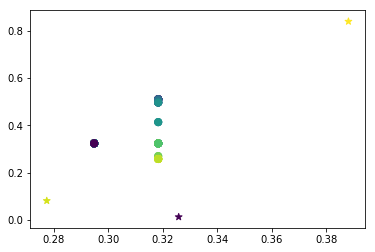

In [44]:
plt.figure(); plt.scatter(resulting_thetas[0], resulting_thetas[1], c=resulting_thetas[2], s=50)
plt.scatter(true_thetas[0], true_thetas[1], c=true_thetas[2], s=50,  marker='*')

In [ ]:
## old clustering
import cvxpy as cvx

## method for taking data points into cvxpy problem and solving it
def cvx_problem(zs, labels):
    s = np.unique(labels).size
    
    Ms = []
    ms = []
    ws = []
    for i in range(s):
        selected_z = zs[np.where(cluster_labels == 0)]
        num_selected = selected_z.shape[0]
        M = np.hstack([selected_z,np.ones([num_selected,1])])
        Ms.append(M); ms.append(num_selected)
        ws.append(cvx.Variable(zs[0].size + 1,1))
        
    ys = []
    cost = 0
    constr = []
    for i in range(s):
        for j in range(s):
            if i == j: continue;
            ys.append(cvx.Variable(ms[i]))
            cost = cost + np.ones(ms[i]).dot(ys[-1]) / ms[i]
            print(Ms[i].shape)
            print(ws[j], ws[i], ys[-1])
            constr.append(0 >= Ms[i] * ws[j] + np.ones([ms[i],1]) )
            #constr = constr + [ys[-1] >= Ms[i].dot(ws[j] - ws[i]) + np.ones([ms[i],1]), ys[-1] >= 0]
            
    return cvx.Problem(cvx.Minimize(cost), constr), thetas
    
    